In [19]:
import numpy as np
import pandas as pd
import sklearn
import math 
from typing import AnyStr, Callable
from sklearn.base import ClusterMixin,BaseEstimator
from scipy.cluster.hierarchy import ward, cut_tree
from sklearn.metrics import make_scorer
from sklearn.cluster import AffinityPropagation

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

In [3]:
A = [1,20,1,20,20,1,100,100,100]
B = [100,30,100,30,30,100,1,1,1]
norm_data = np.array([A,B])
y_test = [1,2,1,2,2,1,3,3,3]

In [4]:
model = IterativeClustering(np.unique(y_test),compute_precision,True)
cell_clusters,co_clustering,cell_clusters_correlation  = model.fit(norm_data,y_test,N=2, iterations=5)

In [5]:
cell_clusters

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  2.],
       [ 1.,  1.,  1.,  2., nan],
       [ 1.,  1.,  2., nan, nan],
       [ 1.,  2.,  3., nan, nan],
       [ 1.,  2.,  3., nan, nan],
       [ 1.,  2.,  4., nan, nan]])

In [12]:
class AffinityPropClustering(ClusterMixin, BaseEstimator):
    '''
    Families clustering
    Affinity Propagation clustering
    Parameters
    ----------
    family_interest: np.array,
        list of family of interest
    Scoring : Callable,
        scoring function use to evaluate the model
    maximize: bool,
        if True the scoring function is maximize, else it is minimize
    damping: float,
        damping factor in the range [0.5, 1.0) is the extent to which the current value is maintained relative to incoming values (weighted 1 - damping). 
        This in order to avoid numerical oscillations when updating these values (messages).
    preference: rray-like of shape (n_samples,) or float,
        Preferences for each point - points with larger values of preferences are more likely to be chosen as exemplars. T
        he number of exemplars, ie of clusters, is influenced by the input preferences value. If the preferences are not passed as arguments, they will be set to the median of the input similarities.
    affinity: str,
        Which affinity to use. At the moment ‘precomputed’ and euclidean are supported. ‘euclidean’ uses the negative squared euclidean distance between points.
    
        
    Attributes
    ----------
    n_clusters_ : int
        The number of clusters found by the algorithm.
    labels_ : ndarray of shape (n_samples)
        Cluster labels for each point.
    family_interest: np.array,
        list of family of interest.
    Scoring : Callable,
        scoring function use to evaluate the model.
    maximize: bool,
        if True the scoring function is maximize, else it is minimize.
    
    '''
    
    def __init__(self, family_interest_:np.array, Scoring_:Callable, maximize_:bool, damping:float=0.5, preference:float=None, affinity:str='euclidean'):
        super().__init__()
        self.family_interest_ = family_interest_
        self.Scoring_ = Scoring_
        self.maximize_ = maximize_
        self.damping_ = damping
        self.preference_ = preference
        self.affinity_ = affinity
        
    def fit(self, X:np.array, y:np.array):
        '''Fit data using affinity clustering.
        
        parameters:
        -------
        x : np.array,
            features of each data points
        y : np.array,
            family of each data points
        

        Returns
        -------
        self,
            return fitted self'''
        
        corr = X
        if self.affinity_ == 'precomputed':
            #Compute the spearman correlation of X if affinity chosen is precomputed
            X_pd = pd.DataFrame(X.T)
            corr= X_pd.corr(method= 'spearman')
            corr= np.array((1 - corr)/2)
        
        #Fit and predict cluster on data
        model = AffinityPropagation(damping=self.damping_, max_iter=200, convergence_iter=15, copy=True, preference=self.preference_, affinity= self.affinity_, random_state=3)
        clustering = model.fit_predict(X)

        #Score the cluster and determine the number of clusters
        score = self.Scoring_(y,clustering)
        N = len(np.unique(clustering))
   
        self.n_clusters_, self.labels_, self.score_ = N, clustering, score
        return self
    
    def fit_predict(self, X:np.array, y:np.array):
        self.fit(X,y)
        
        return self.labels_      
    
    def score(self, X, y_true):
        #Error come from here y_true and X not same size as self.labels_ -> function fit_as
        return self.score_

In [26]:
class GaussianMixClust(ClusterMixin, BaseEstimator):
    '''
    Families clustering
    Affinity Propagation clustering
    Parameters
    ----------
    family_interest: np.array,
        list of family of interest
    Scoring : Callable,
        scoring function use to evaluate the model
    maximize: bool,
        if True the scoring function is maximize, else it is minimize
    damping: float,
        damping factor in the range [0.5, 1.0) is the extent to which the current value is maintained relative to incoming values (weighted 1 - damping). 
        This in order to avoid numerical oscillations when updating these values (messages).
    preference: rray-like of shape (n_samples,) or float,
        Preferences for each point - points with larger values of preferences are more likely to be chosen as exemplars. T
        he number of exemplars, ie of clusters, is influenced by the input preferences value. If the preferences are not passed as arguments, they will be set to the median of the input similarities.
    affinity: str,
        Which affinity to use. At the moment ‘precomputed’ and euclidean are supported. ‘euclidean’ uses the negative squared euclidean distance between points.
    
        
    Attributes
    ----------
    n_clusters_ : int
        The number of clusters found by the algorithm.
    labels_ : ndarray of shape (n_samples)
        Cluster labels for each point.
    family_interest: np.array,
        list of family of interest.
    Scoring : Callable,
        scoring function use to evaluate the model.
    maximize: bool,
        if True the scoring function is maximize, else it is minimize.
    
    '''
    
    def __init__(self, family_interest_:np.array, Scoring_:Callable, maximize_:bool, damping:float=0.5, preference:float=None, affinity:str='euclidean'):
        super().__init__()
        self.family_interest_ = family_interest_
        self.Scoring_ = Scoring_
        self.maximize_ = maximize_
        n_components=1, *, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10

    def fit(self, X:np.array, y:np.array):
        '''Fit data using affinity clustering.
        
        parameters:
        -------
        x : np.array,
            features of each data points
        y : np.array,
            family of each data points
        

        Returns
        -------
        self,
            return fitted self'''
        corr = X
        if self.affinity_ == 'precomputed':
            #Compute the spearman correlation of X if affinity chosen is precomputed
            X_pd = pd.DataFrame(X.T)
            corr= X_pd.corr(method= 'spearman')
            corr= np.array((1 - corr)/2)
        
        #Fit and predict cluster on data
        model = AffinityPropagation(damping=self.damping_, max_iter=200, convergence_iter=15, copy=True, preference=self.preference_, affinity= self.affinity_, random_state=3)
        clustering = model.fit_predict(corr)

        #Score the cluster and determine the number of clusters
        score = self.Scoring_(y,clustering)
        N = len(np.unique(clustering))
   
        self.n_clusters_, self.labels_, self.score_ = N, clustering, score
        return self
    
    def fit_predict(self, X:np.array, y:np.array):
        self.fit(X,y)
        
        return self.labels_      
    
    def score(self, X, y_true):
        #Error come from here y_true and X not same size as self.labels_ -> function fit_as
        return self.score_

# Ward

In [17]:
#Load preprocess data
AE3= np.array(pd.read_csv ('../data/processed_data/AE3.csv'))
y = np.array(AE3[:,-1],dtype=int)
AE3 = AE3[:,0:-1]

#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE3,y)

acc = model.score_
print('precision',acc)
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

print(len(np.unique(pred)))

precision 0.3159509202453988
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (103.0, 223.0, 0.4618834080717489, 0.37050359712230213, 0.9921779087305763, 0.3159509202453988, 0.9938512350233653, 0.6840490797546013, 0.6294964028776978)
162


# Affinity propagation

In [35]:
#Predict and evaluate
model =  AffinityPropClustering(np.unique(y),compute_precision,True,damping=0.5, preference=None,  affinity='euclidean')
pred = model.fit_predict(AE3,y)

acc = model.score_
print('precision',acc)
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

print(len(np.unique(pred)))

precision 0.03819316929856775
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (104.0, 2619.0, 0.039709812905689194, 0.8739495798319328, 0.48363564668769715, 0.03819316929856775, 0.9939222042139384, 0.9618068307014322, 0.12605042016806722)
34


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:246: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


test 0.16645220315162587 0.014412903701241861
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (152.0, 2100.0, 0.07238095238095238, 0.9620253164556962, 0.45141065830721006, 0.0674955595026643, 0.9965397923875432, 0.9325044404973357, 0.0379746835443038)


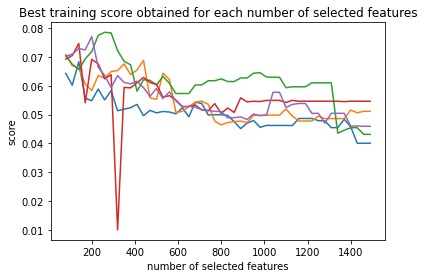

In [21]:
#Define parameters for MIM method
N = np.arange(80,1500,30)
kwargs = {'Model': AffinityPropClustering, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE3, AffinityPropClustering, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = AffinityPropClustering(np.unique(y),compute_precision,True)
x_subset = AE3[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Gaussian mixture model

In [ ]:
#Predict and evaluate
model =  GaussianMixClust(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE3,y)

acc = model.score_
print('precision',acc)
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

print(len(np.unique(pred)))